# Repeated parity measurement photon counting 

In [1]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from h5py import File
import os
from slab.dataanalysis import get_next_filename

C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "
C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Could not load InstrumentManagerWindow


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y
def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# HMM Model

In [3]:
class hmm_analysis:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

        fn_file = cal_path + '\\00000_2021_11_09_cavity_square_mode_2.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename, at_end=True, t2_err = 0.0):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = 0.03, 0.03
        
        self.a = self.openfile(data_filename)

        bit1 = np.array(self.a['bit1'])[:]
        bit2 = np.array(self.a['bit2'])[:]
        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        p_cav = np.array(self.a['p_cav'])/100
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))

        self.a.close()
        
        df = bit3
        alpha = self.alpha_awg_cal(cav_amp, cav_len)
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        nx, ny = np.shape(df)
                
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l

        df['n'] = 2*bit2 + bit1

        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols].sort_values(by=['n'])

        """Find out the unique Fock levels and their occurences"""

        (unique, counts) = np.unique(df['n'], return_counts=True)

        print(unique, counts)
        
        p_m_counts = []
        p_n_counts = []
        
        index = 0
        for ii in range(len(unique)):
            pm_temp = []
            pn_temp = []
            
            fstate_in = unique[ii]+1

            cavity_t1 = self.cavity_t1/fstate_in
            Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

            Pmn = self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
            Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
                (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)
            Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)

            T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
                 [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
                 [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
                 [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

            E = 0.5*asarray([[1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity],
                [1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity]])
            
            for jj in range(counts[ii]):
                """State preparation probabilities at the end or at the beginning of m π pulses"""
                meas_seq = df.iloc[index + jj][1:1+npi_m]
                gamma_matrix = self.gamma(meas_seq, T, E)
                if at_end==True: #Probablitity of state surviving till the end
                    P0_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                    P1_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
                else:#Probability at the beginnning
                    P0_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                    P1_last = gamma_matrix[0,2] + gamma_matrix[0,3]   
                pm_temp.append(P1_last/P0_last)

                """After the coherent drive, probabilities at the begining of n π pulses"""    
                meas_seq = df.iloc[index + jj][npi_m:]
                gamma_matrix = self.gamma(meas_seq, T, E)
                P0_first = gamma_matrix[0,0] + gamma_matrix[0,1]
                P1_first = gamma_matrix[0,2] + gamma_matrix[0,3]   
                pn_temp.append(P1_first/P0_first)

            index = index + counts[ii]
            p_m_counts.append(pm_temp)
            p_n_counts.append(pn_temp)

        return alpha, unique, counts, p_m_counts, p_n_counts

# Photon counting HMM

In [5]:
class hmm_analysis_pc:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']
        self.g_inf = readout_params['g_inf']        
        self.e_inf = readout_params['e_inf']        

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = np.zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = np.zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = np.argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

        fn_file = cal_path + '\\00000_2021_12_16_cavity_square_mode_2.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):

        return File(filename,'r')

    def stateprep(self, fstate_in=0, data_filename=None, at_end=False, t2_err=0.0):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = self.g_inf, self.e_inf
        
        self.a = self.openfile(data_filename)

        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))
        alpha = np.array(self.a['alpha'])

        self.a.close()
        
        df = bit3
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        nx, ny = np.shape(df)
                
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l
        
        p_m_counts = []
        
        """T and E matrices for the HMM analysis"""
        fstate_in = 0

        if fstate_in ==0:
            cavity_t1 = self.cavity_t1/(fstate_in+1)
            Pnm =  self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))
        else: 
            cavity_t1 = self.cavity_t1/(fstate_in)
            Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

        Pmn = self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\

        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)

        T = np.asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
             [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
             [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
             [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

        E = 0.5*np.asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])
            
        for jj in range(len(df)):
            """State preparation probabilities at the end or at the beginning of m π pulses"""
            meas_seq = df.iloc[jj]
            gamma_matrix = self.gamma(meas_seq, T, E)
            if at_end==True: #Probablitity of state surviving till the end
                P0_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                P1_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
            else:#Probability at the beginnning
                P0_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                P1_last = gamma_matrix[0,2] + gamma_matrix[0,3]   
            p_m_counts.append(P1_last/P0_last)

        return alpha, cav_amp, p_m_counts

In [4]:
3.2+.476+.160

3.8360000000000003

# Varying injected alpha

## 0.0

In [6]:
qubit_params = {'t1':125, 't2':127, 'nth':1e-2}
cavity_params = {'t1':1.3e3, 'nth':0.006}
readout_params = {'length':3.2, 'trigger':4.720, 'pi_pulse':(476+160)*1e-3, 'g_inf':0.04, 'e_inf':0.04}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(113, 140, 1)
# filelist = [88]
p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_pc(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00113_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.001, length = 40 ns
..\data\00114_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.002, length = 40 ns
..\data\00115_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.003, length = 40 ns
..\data\00116_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.004, length = 40 ns
..\data\00117_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.005, length = 40 ns
..\data\00118_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.006, length = 40 ns
..\data\00119_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.007, length = 40 ns
..\data\00120_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.008, length = 40 ns
..\data\00121_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0


In [16]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=40*np.ones(len(camp)))
print(alphas)

[0.05560683 0.00119356 0.0027341  0.00419833 0.00545181 0.00709248
 0.00859861 0.00984322 0.01145634]


In [7]:
# alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/mode2_112022/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(40)+".h5"
    print(filename)
    
    temp= p_m_counts[i]

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/mode2_112022/n0_camp_0.001_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.002_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.003_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.004_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.005_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.006_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.007_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.008_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.009_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.01_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.02_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.03_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.04_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.05_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.06_len_40.h5
../data/photon_counting/mode2_112022/n0_camp_0.07_len_40.h5
../data/photon_counting/mode2_1

# Debug

In [33]:
qubit_params = {'t1':121, 't2':210, 'nth':1e-2}
cavity_params = {'t1':1.6e3, 'nth':0.006}
readout_params = {'length':3.0, 'trigger':4.520, 'pi_pulse':(476+80)*1e-3, 'g_inf':0.0244, 'e_inf':0.0372}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(14, 22, 1)
filelist = [88]
p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_pc(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00080_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.01, length = 40 ns
..\data\00081_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.02, length = 40 ns
..\data\00082_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.03, length = 40 ns
..\data\00083_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.04, length = 40 ns
..\data\00084_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.05, length = 40 ns
..\data\00085_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.06, length = 40 ns
..\data\00086_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.07, length = 40 ns
..\data\00087_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.08, length = 40 ns


In [34]:
# alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=40*np.ones(len(camp)))

path = "../data/photon_counting/mode2/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(40)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/mode2/n0_camp_0.01_len_40.h5
../data/photon_counting/mode2/n0_camp_0.02_len_40.h5
../data/photon_counting/mode2/n0_camp_0.03_len_40.h5
../data/photon_counting/mode2/n0_camp_0.04_len_40.h5
../data/photon_counting/mode2/n0_camp_0.05_len_40.h5
../data/photon_counting/mode2/n0_camp_0.06_len_40.h5
../data/photon_counting/mode2/n0_camp_0.07_len_40.h5
../data/photon_counting/mode2/n0_camp_0.08_len_40.h5


In [136]:
alphas[0]

0.11149109596782633

In [6]:
xa, b = np.where(np.array(p_m_counts)>1e4)
print(len(b))

10


In [7]:
len(b)/len(bit3)

NameError: name 'bit3' is not defined

In [8]:
h = np.array(bit3.iloc[b[3]])

NameError: name 'bit3' is not defined

In [11]:
h.shape[0]

30

In [12]:
bit3

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [114]:
##----------------------------------------------------------------##
def forward(meas_seq, T, E):
    num_meas = len(meas_seq)
    N = T.shape[0]
    alpha = zeros((num_meas, N))
    pi = [0.25, 0.25, 0.25, 0.25]
    alpha[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
    return alpha

def backward(meas_seq, T, E):
    N = T.shape[0]
    num_meas = len(meas_seq)
    beta = zeros((N,num_meas))
    beta[:,-1:] = 1
    for t in reversed(range(num_meas-1)):
        for n in range(N):
            beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
    return beta

def likelihood(meas_seq, T, E):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return  forward(meas_seq, T, E)[-1].sum()

def gamma( meas_seq, T, E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha, beta.T) / obs_prob)


def viterbi(meas_seq, T, E):
    # returns the most likely state sequence given observed sequence x
    # using the Viterbi algorithm
    num_meas = len(meas_seq)
    N = T.shape[0]
    delta = zeros((num_meas, N))
    psi = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25]
    delta[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        for j in range(N):
            delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
            psi[t,j] = argmax(delta[t-1]*T[:,j])

    # backtrack
    states = zeros(num_meas, dtype=int32)
    states[num_meas-1] = argmax(delta[num_meas-1])
    for t in range(num_meas-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


qubit_params = {'t1':120, 't2':190, 'nth':1e-2}
cavity_params = {'t1':1e3, 'nth':0.006}
readout_params = {'length':3.044, 'trigger':4.520, 'pi_pulse':0.476}

qubit_t1 = qubit_params['t1']
qubit_t2 = qubit_params['t2']
qubit_nth = qubit_params['nth']
cavity_t1 = cavity_params['t1']
cavity_nth = cavity_params['nth']

readout_len = readout_params['length']        
trigger_period = readout_params['trigger']
pi_length = readout_params['pi_pulse']

"""Readout fidelities from an independent measurement"""
g_infidelity, e_infidelity = 0.03, 0.03

fstate_in = 0

if fstate_in == 0:
    cavity_t1 = cavity_t1/1
    Pnm =  cavity_nth * (1-np.exp(-trigger_period/cavity_t1))
else:
    cavity_t1 = cavity_t1/fstate_in
    Pnm =  (1-np.exp(-trigger_period/cavity_t1)) + cavity_nth * (1-np.exp(-trigger_period/cavity_t1))

    
# P01 = cav_n * (1-exp(-trigger_period/cav_t1))
# P10 = 1-exp(-trigger_period/cav_t1)
    
Pmn = cavity_nth * (1-exp(-trigger_period/cavity_t1)) + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_nth * (1-np.exp(-trigger_period/qubit_t1)) +\
    (1-np.exp(-pi_length/qubit_t2))
Peg = (1-np.exp(-trigger_period/qubit_t1)) + \
    (1-np.exp(-pi_length/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])


meas_seq = np.array(bit3.iloc[b[3]])
P0_last = []
P1_last = []
print(len(meas_seq))

p_m_temp = []

for kk in range (len(meas_seq[:])):
    temp_meas_sequence = meas_seq[0:kk+1]
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_last.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_last.append(gamma_matrix[0,2] + gamma_matrix[0,3])

30


In [105]:
P0_last[-1], P1_last[-1]

(3.0012858133604015e-05, 0.9999699871418672)

In [75]:
meas_seq

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [68]:
P0_last[-1], P1_last[-1]

(0.9570472395500388, 0.04295276044996086)

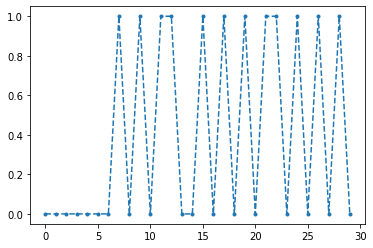

In [69]:
plt.plot(bit3.iloc[b[28]], '.--')

IndexError: index 13 is out of bounds for axis 0 with size 13

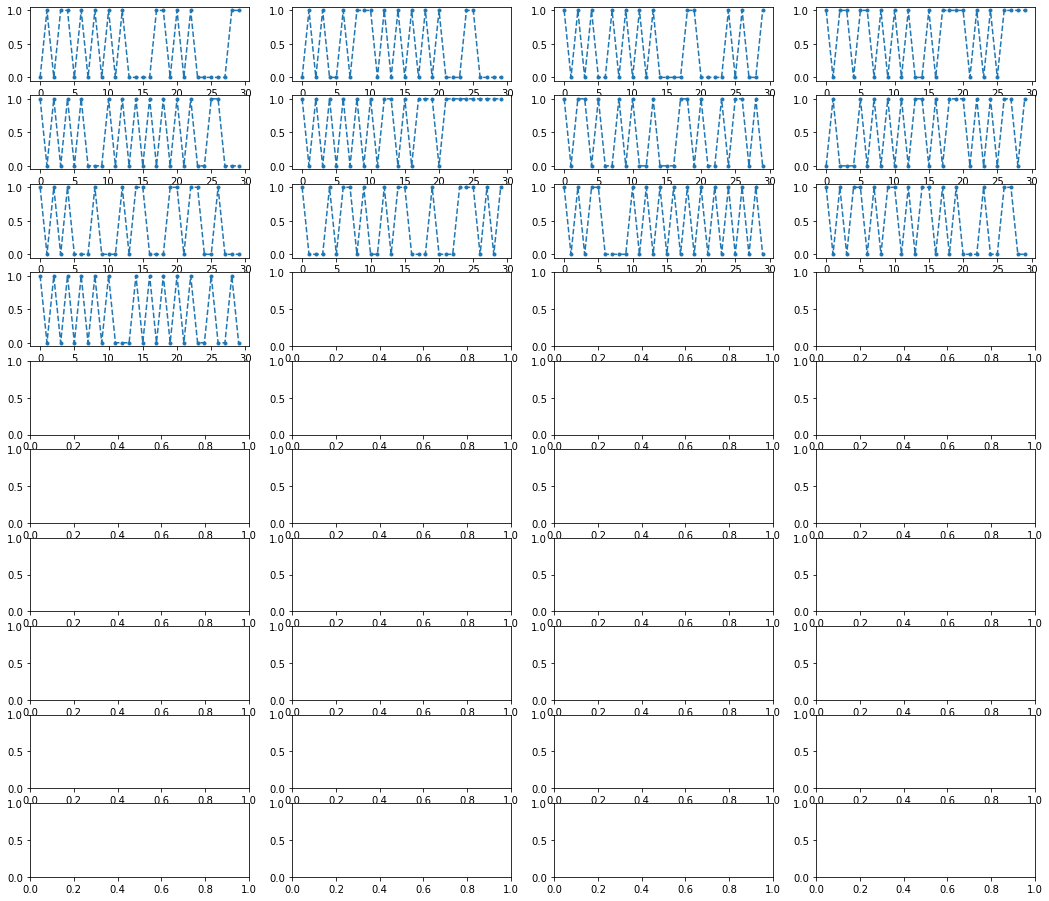

In [13]:
fig, axs = plt.subplots(ncols=4, nrows=10, figsize=(18, 16))

for i in range(33):
    axs[i//4, i%4].plot(bit3.iloc[b[i]], '.--')

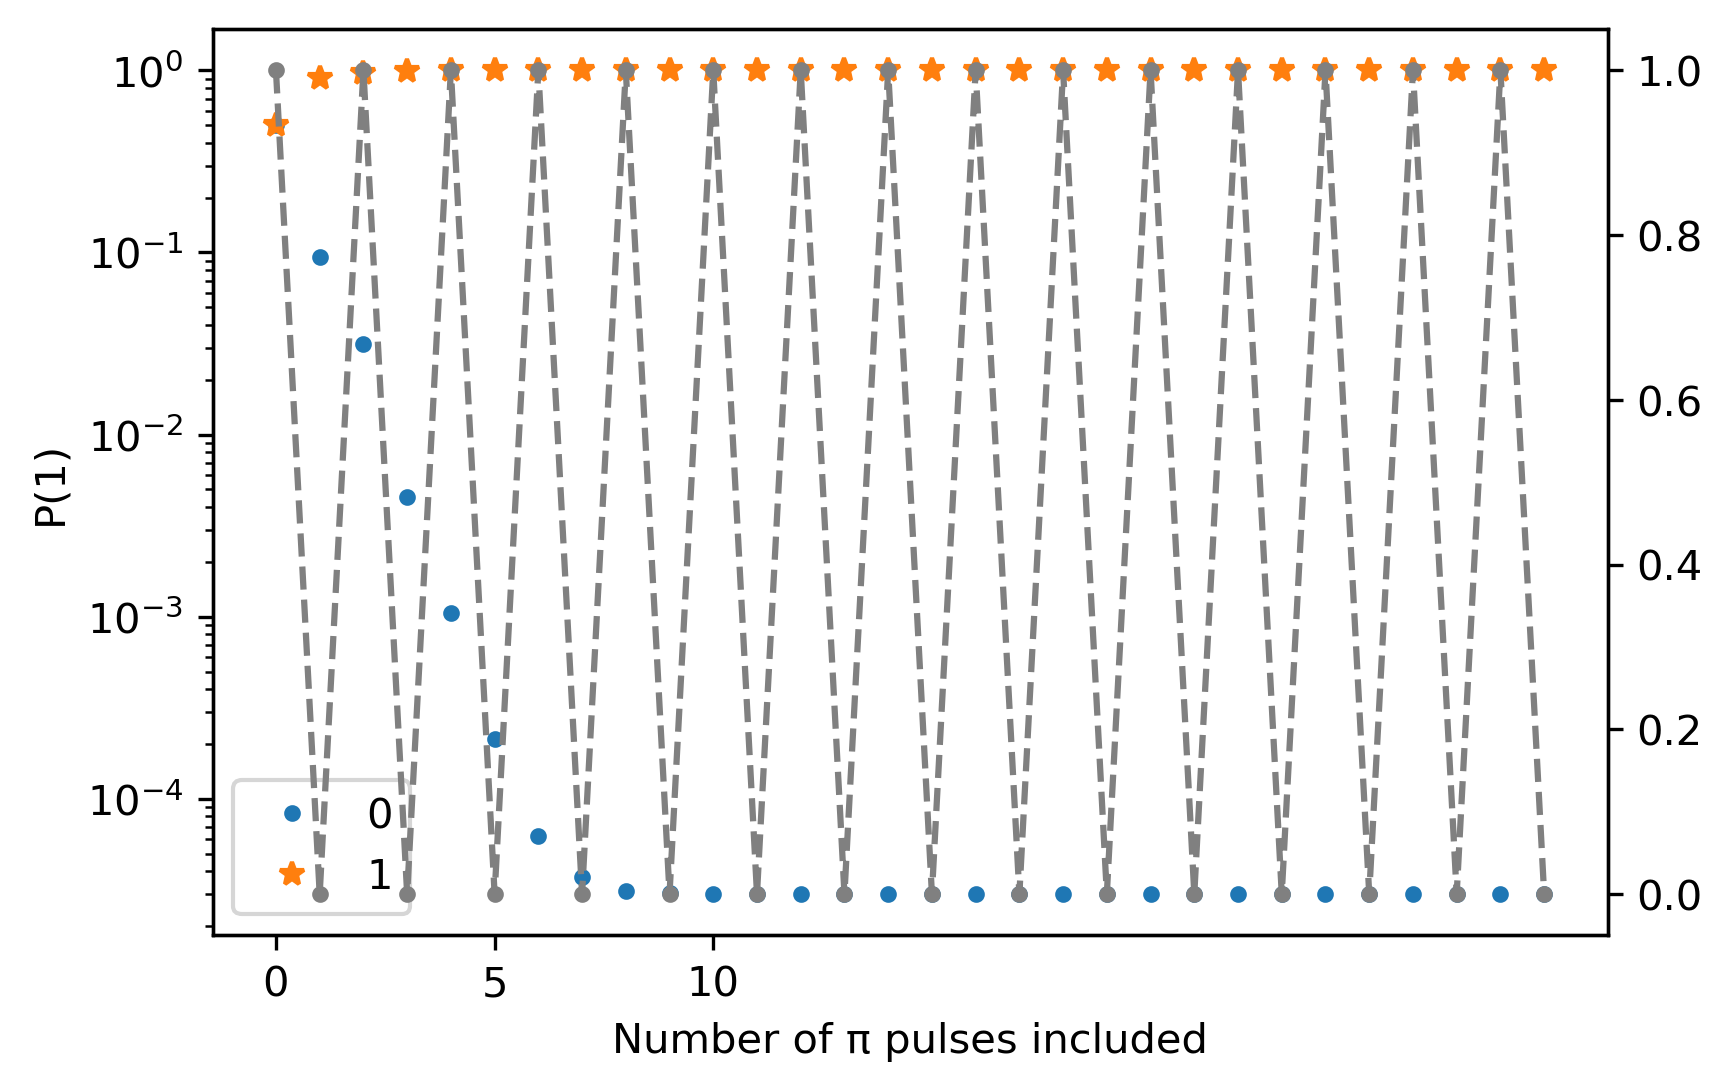

In [106]:
"""### Threshold analysis to estimate the number of pi pulses to be included for < detector based errors"""
fig, axs = plt.subplots(1, 1, dpi=300)

n = np.arange(30)

axs.semilogy(np.array(P0_last), '.', label='0')
axs.semilogy(np.array(P1_last), '*', label='1')
axs.set_ylabel('P(1)')
axs.set_xlabel('Number of π pulses included')

ax1 = axs.twinx()

ax1.plot(meas_seq[:],'.--', color='grey')
plt.xticks([0, 5, 10])

axs.legend(loc='best')
plt.show()

In [65]:
P0_last[-1]/P1_last[-1]

4.2526779380407896e-12

In [58]:
df = pd.DataFrame(bit3)

In [109]:
df.iloc[1899]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    0
Name: 1899, dtype: int64

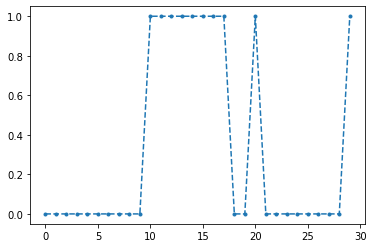

In [104]:
plt.plot(df.loc[2566, :], '.--')

In [43]:
df.iloc[2442]

0     1
1     0
2     1
3     0
4     0
5     0
6     0
7     1
8     0
9     1
10    0
11    1
12    0
13    1
14    1
15    0
16    0
17    1
18    0
19    1
20    0
21    1
22    0
23    1
24    0
25    1
26    1
27    1
28    1
29    0
Name: 2442, dtype: int64

0.0010258697591436217 0.0003301066625261794
Chi:  1.533 MHz
Kappa:  0.9164941176470588 MHz
Cavity Occupation 0.00019
Cavity temperature = 39.52819891153918 mK
Cavity temperature+ = 41.02976384747982 mK
Cavity temperature- = 37.85207105017337 mK


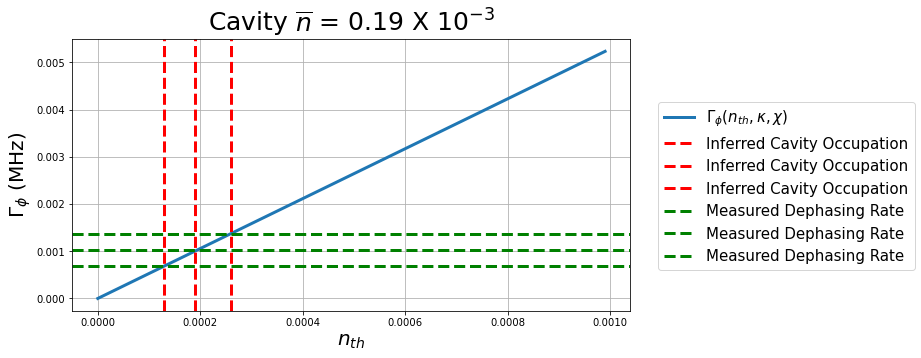

In [79]:
T2 =190
T2err = 10
T1 = 118
T1err = 10

gph  = 1/(T2) - 1/(2*T1)
gpherr = sqrt( (1/(2*T1))**4*T1err**2 + (1/(T2))**4*T2err**2 )
print (gph, gpherr)
nu_r = 7.7902
Q = 8500.0
kappa = 2*pi*nu_r/Q*1e3
chi = 1.533*2*pi
print ("Chi: ", chi/(2*pi), "MHz")
print ("Kappa: ", kappa/(2*pi), "MHz")
def temperature_cav(nu,mean_n):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log((1+mean_n)/mean_n))
def occupation_cav(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))-1)
def dephasing(kappa,chi,nth):
    return kappa/2.0*real(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa)-1)
def freq_shift(kappa,chi,nth):
    return kappa/2.0*imag(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa))
figure(figsize=(10,5))
subplot(111)
n_th = arange(0.0,0.001,0.00001)
plot(n_th, array([dephasing(kappa,chi,n) for n in n_th] ), label = '$\Gamma_{\phi}(n_{th}, \kappa, \chi)$', linewidth=3)
n_cav = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - gph))]
n_cav_pluserr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph+gpherr)))]
n_cav_negerr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph-gpherr)))]
print ("Cavity Occupation", n_cav)
axvline(n_cav,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_pluserr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_negerr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axhline(gph,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph+gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph-gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
ylabel('$\Gamma_{\phi}$ (MHz)', fontsize='20')
xlabel('$n_{th}$', fontsize='20')
title('Cavity $\overline{n}$ = %s X $10^{-3}$' %(n_cav*1e3), fontsize='25')
grid()
legend(loc=(1.05,0.15),fontsize='15')
print ("Cavity temperature = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav)))
print ("Cavity temperature+ = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_pluserr)))
print ("Cavity temperature- = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_negerr)))

In [ ]:
()

# photon counter fit

In [13]:
data_path =  "../data/photon_counting/mode2_112022//"
filenames_like = os.listdir(data_path)

th_m = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_m:
        df = pd.DataFrame(p_m_counts)
        count_m = df[df>th].count()
        t = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_m)/len(p_m_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_m_counts), count_m))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n0_camp_0.001_len_40.h5
0.000723
Total number of events collected: 10000, 16 events crossed \lambda 
n0_camp_0.002_len_40.h5
0.001447
Total number of events collected: 10000, 11 events crossed \lambda 
n0_camp_0.003_len_40.h5
0.00217
Total number of events collected: 10000, 13 events crossed \lambda 
n0_camp_0.004_len_40.h5
0.002894
Total number of events collected: 10000, 16 events crossed \lambda 
n0_camp_0.005_len_40.h5
0.003617
Total number of events collected: 10000, 11 events crossed \lambda 
n0_camp_0.006_len_40.h5
0.004341
Total number of events collected: 10000, 10 events crossed \lambda 
n0_camp_0.007_len_40.h5
0.005048
Total number of events collected: 10000, 13 events crossed \lambda 
n0_camp_0.008_len_40.h5
0.006113
Total number of events collected: 10000, 11 events crossed \lambda 
n0_camp_0.009_len_40.h5
0.006713
Total number of events collected: 10000, 4 events crossed \lambda 
n0_camp_0.01_len_40.h5
0.007523
Total number of events collected: 10000, 15 events crossed \l

In [14]:
th_m

array([   10.,   100.,  1000., 10000.])

In [15]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_m)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])

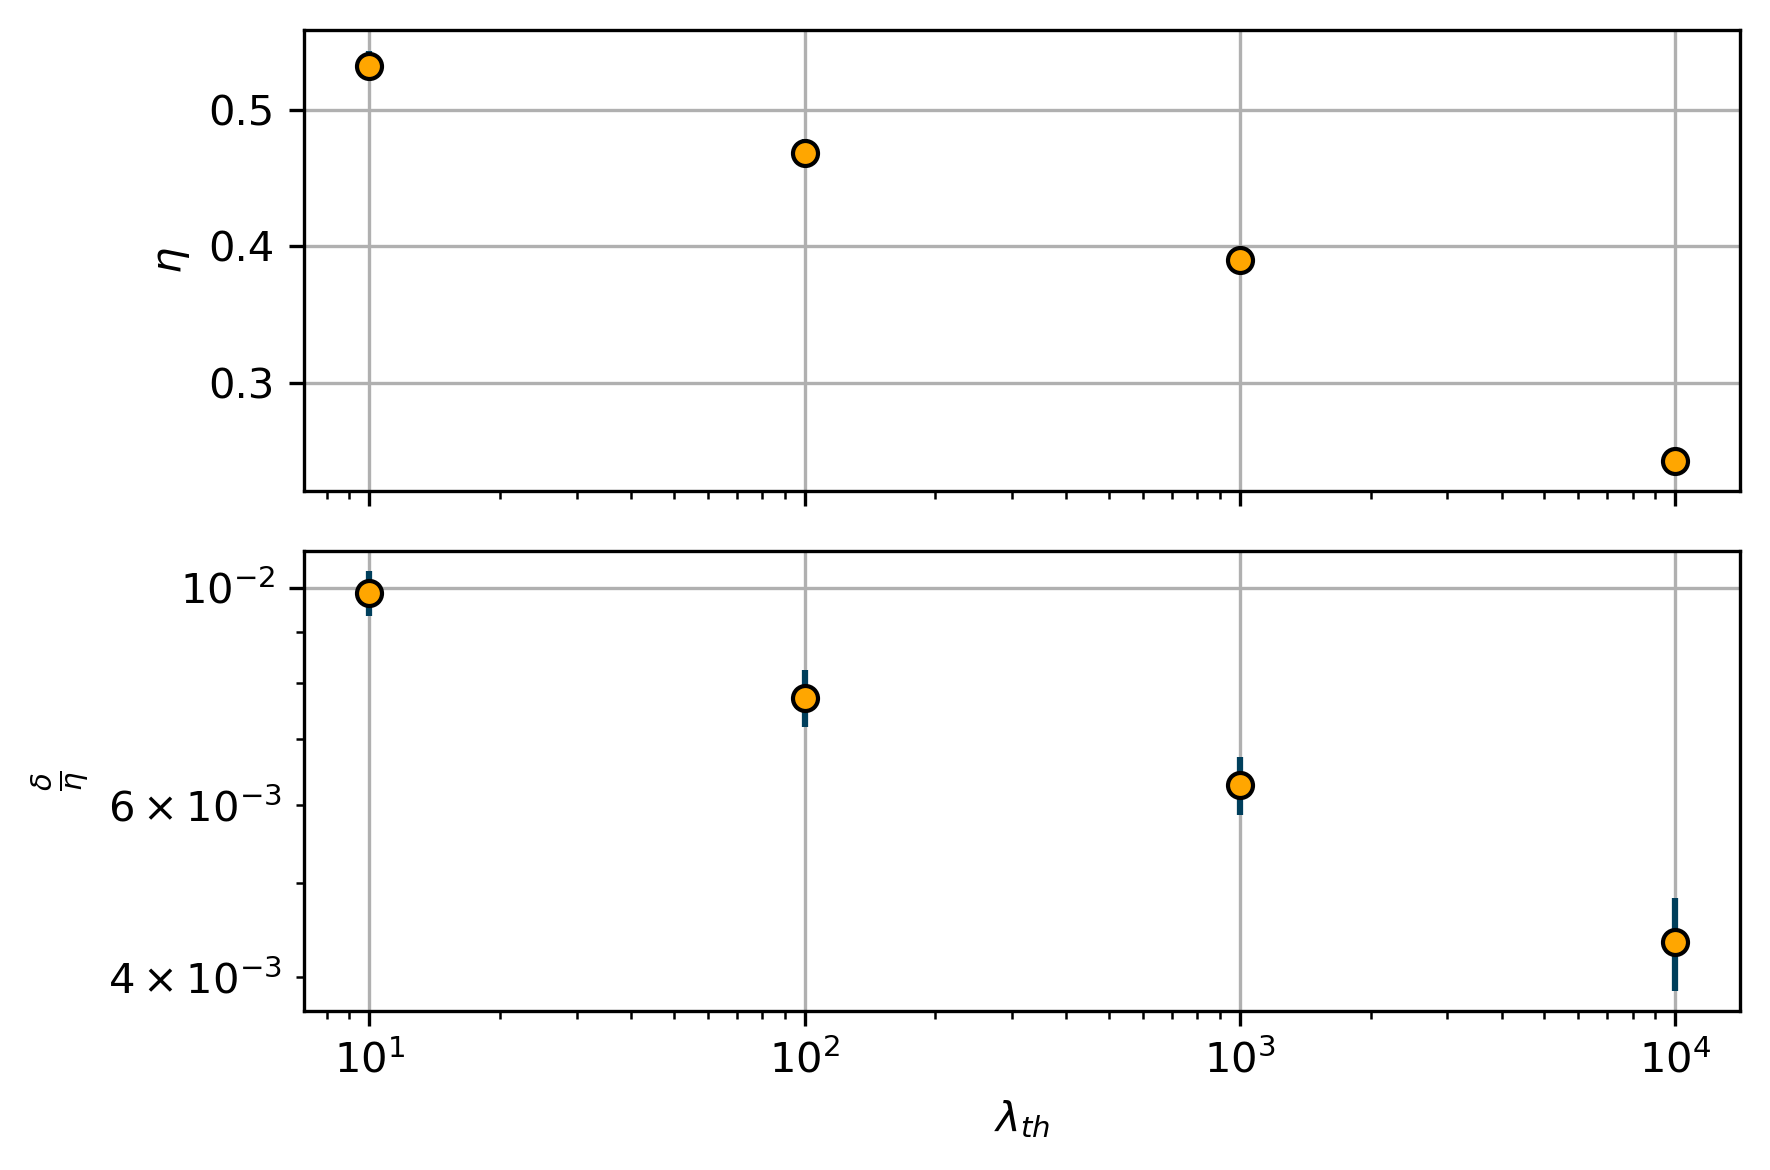

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_m, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_m, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.05265


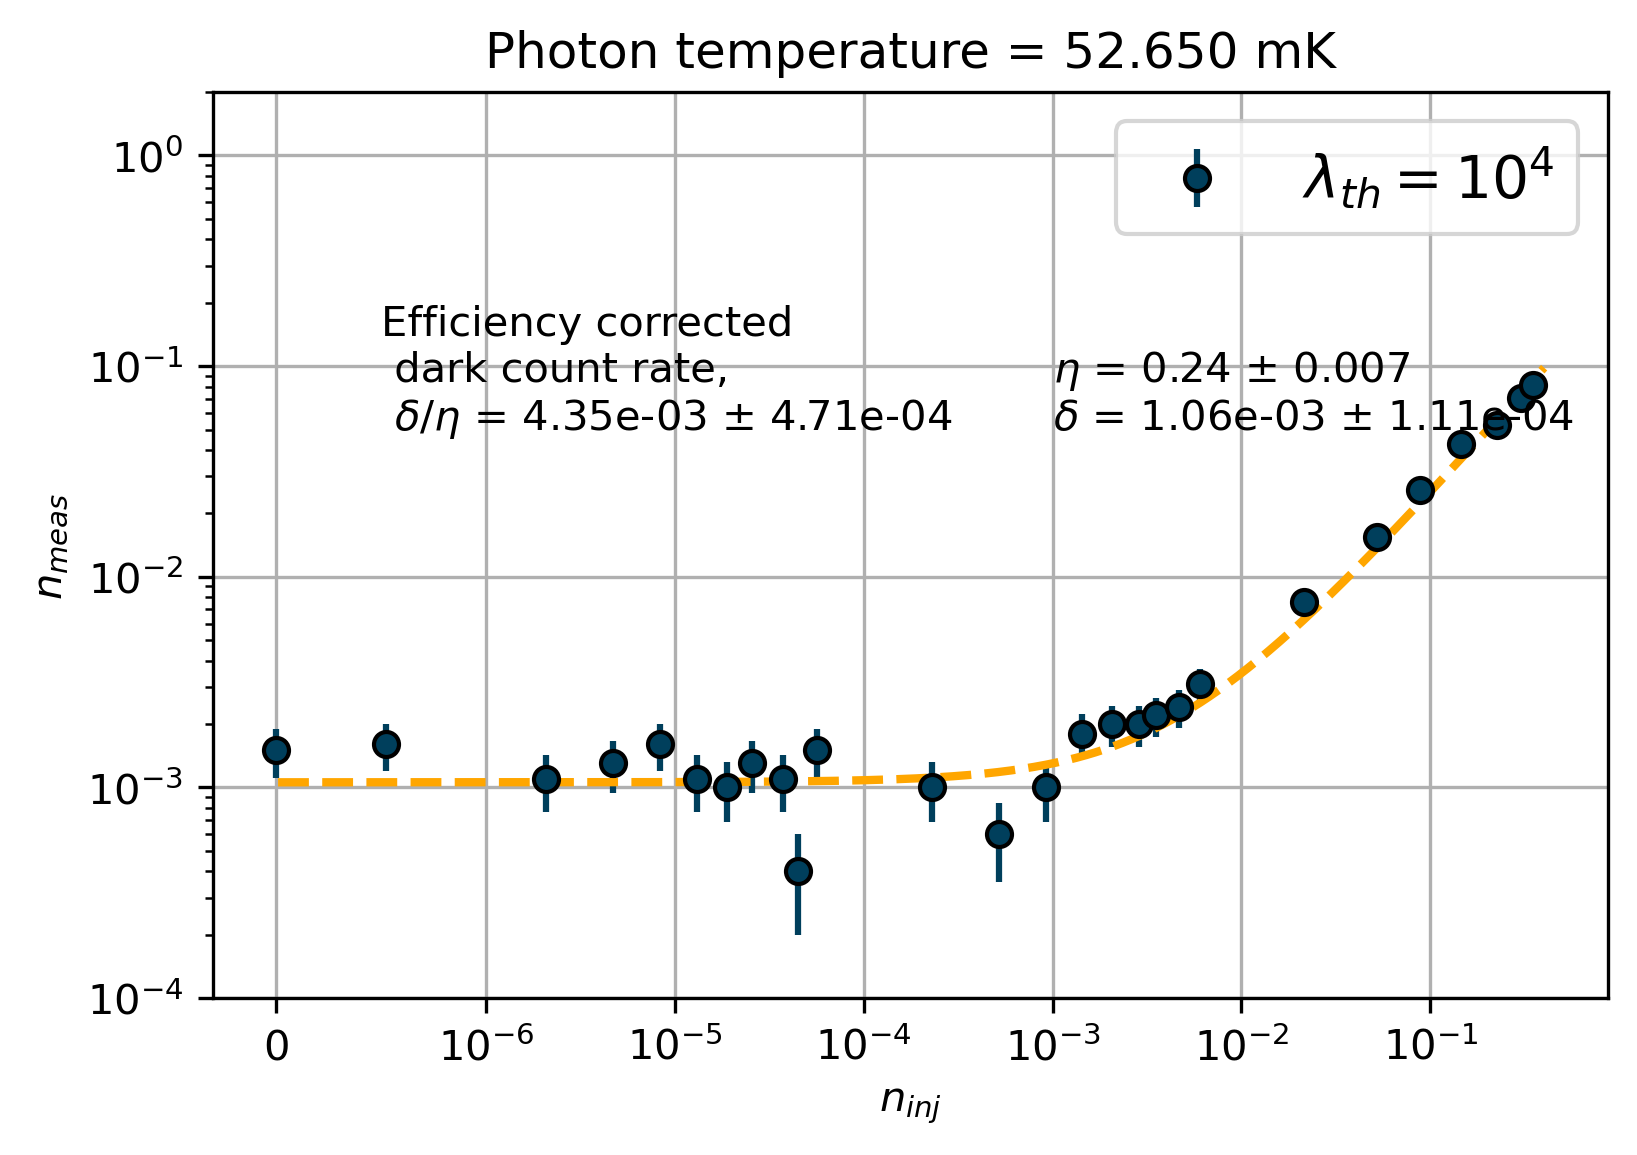

In [11]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_m[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*5.965085549955351*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 2e0)
plt.text(1e-3, 5e-2, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-08-01-PhotonCounting.png', dpi=300)
plt.show()

In [73]:
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/3.28e-4))
print(T)

0.03595919112878462


In [108]:
filename = '..//data//stim_em//00000_analysis_params.json'
import json
 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)

In [111]:
data['readout_params ']

{'length': 3.2,
 'trigger': 7.72,
 'pi_pulse': 3,
 'g_inf': 0.0323,
 'e_inf': 0.0447}

In [89]:
str(qubit_params)

'b"{\'t1\': 118, \'t2\': 194, \'nth\': 0.03}"'

In [81]:
import ast
qubit_params = ast.literal_eval(str(data))

In [83]:
qubit_params['t1']

TypeError: byte indices must be integers or slices, not str